# Using DSI for AI training
In this demo, we shouw how to load data from datacards to a DSI database and then do training on it

In [17]:
import os
import pandas as pd
from dsi.dsi import DSI
import utils

In [2]:
# Sometimes certificates are an issue with zscale, something like this helps
os.environ["REQUESTS_CA_BUNDLE"] = "/Users/pascalgrosset/Zscaler-Root-CA.pem"
os.environ["SSL_CERT_FILE"] = "/Users/pascalgrosset/Zscaler-Root-CA.pem"

In [3]:
# Initialize some variables
image_path = "images/"
input_csv = "wildfire/wildfiredata.csv"
db_name = 'wildfire.db'
datacard = "firetec_genesis_datacard.xlsx"
table_name = "wfdata"
columns_to_keep = ["wind_speed", "wdir", "smois", "burned_area"]

In [4]:
# Downloads the URLs to local filepaths
if not os.path.exists(image_path):
    os.makedirs(image_path)
utils.downloadImages(input_csv, image_path)

# Do some cleanup
if os.path.exists(db_name):
    os.remove(db_name)

## Create the DSI database

In [5]:
dsi = DSI(db_name)  # create the DSI database

dsi.read(input_csv, "Ensemble", table_name=table_name) # read in the data
dsi.read(datacard, "GenesisDatacard")                  # read in the datacard

Created an instance of DSI with the Sqlite backend: wildfire.db
Loaded wildfire/wildfiredata.csv into tables: wfdata, simulation
Loaded firetec_genesis_datacard.xlsx into the table genesis_datacard


### Do some processing on DSI data, counting burned area

In [6]:
# Extract the first 10 rows
wildfire_data = dsi.get_table(table_name, True, True).head(10)

Storing all data for the table: wfdata as a collection
Note: Includes 'dsi_table_name' column for dsi.update(); DO NOT modify. Drop if not updating data.


In [7]:
# Adds a shorter filepath column to the dataframe
updatedFilePaths = []
for url_image in wildfire_data['FILE']:
    image_name = url_image.rsplit('/', 1)[1]
    filePath = image_path + image_name
    updatedFilePaths.append(filePath)
wildfire_data['LOCAL_PATH'] = updatedFilePaths

In [8]:
# count pixels
wildfire_data = utils.count_burned_pixels(wildfire_data)

In [9]:
# Updates the DSI database and displays a few columns of the table including the new burned_area column
dsi.update(wildfire_data)
dsi.display(table_name, display_cols=columns_to_keep)

Updating the active backend with the input collection of data

Table: wfdata

wind_speed | wdir  | smois | burned_area
----------------------------------------
2.0        | 180.0 | 0.05  | 122388.0   
8.0        | 225.0 | 0.05  | 169302.0   
8.0        | 195.0 | 0.05  | 187542.0   
5.0        | 240.0 | 0.05  | 181583.0   
8.0        | 225.0 | 0.05  | 168955.0   
8.0        | 225.0 | 0.05  | 83722.0    
8.0        | 225.0 | 0.05  | 183566.0   
3.0        | 180.0 | 0.05  | 104288.0   
12.0       | 255.0 | 0.05  | 140347.0   
12.0       | 240.0 | 0.05  | 183895.0   



## Do Some AI training

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score)

Variables that can be customized when training/testing the data.
- TEST_SIZE: % of the data to use for testing. Must be between [0, 1]
- SEED: value used to ensure reproducible results
- features: list of columns to train the data with
- target: one column name that is the target to train the data for
- selected_models: list of models (even if one) to use to train the data. Must be within the all_models list
- selected_metrics: list of metrics (even if one) to evaluate the trained model. Must be within the all_metrics list

In [11]:
# Specify the parameters to run
TEST_SIZE = 0.20
SEED = 15
df = wildfire_data

features = ['wind_speed','wdir','smois','fuels','ignition']
target = "burned_area"

pred_type = "Regression"

all_models = ["Decision Tree", "Random Forest", "KNN", "Linear Regression", "Ridge Regression", "Lasso Regression", "ElasticNet"]
selected_models = ["Decision Tree", "KNN"]

all_metrics = ["MSE", "RMSE", "MAE", "R²"]
selected_metrics = ["MSE"]

In [12]:
# Splits data into X, y based on input features/target.
# Trains/test the X and y values.

X = df[features].select_dtypes(include=[np.number]).fillna(0)
y = df[target]

# if pred_type == "Classification":
y = y.astype("category").cat.codes
X = X.apply(lambda col: col.astype("category").cat.codes)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

### Trains each selected Regression model and evaluates it against the selected metrics.

In [13]:
start_time = time.time()
results = []
for model_name in selected_models:
    grid = None
    if model_name == "Decision Tree":
        param_grid = {'max_depth': [1, 2, 3, 4, 5, 6 ,7, 8, 9, 10, 12, 15, 17, 20, 25, 30, 35, 40, 45, 50],
                    'min_samples_split': [2, 3, 4, 5]}
        if pred_type == "Classification":
            grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='accuracy', error_score='raise')
        else:
            grid = GridSearchCV(DecisionTreeRegressor(random_state=SEED), param_grid, cv=5, scoring='neg_mean_squared_error')
    elif model_name == "Random Forest":
        param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15, 20], 'min_samples_split': [2, 3, 4, 5]}
        if pred_type == "Classification":
            grid = GridSearchCV(RandomForestClassifier(random_state=SEED), param_grid, scoring='accuracy')
        else:
            grid = GridSearchCV(RandomForestRegressor(random_state=SEED), param_grid, scoring='neg_mean_squared_error')
    elif model_name == "KNN":
        param_grid = {'n_neighbors': [3, 4, 5, 6],
                    'weights': ['uniform', 'distance']}
        if pred_type == "Classification":
            grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring='accuracy')
        else:
            grid = GridSearchCV(KNeighborsRegressor(), param_grid, scoring='neg_mean_squared_error')
    elif model_name == "Linear Regression" and pred_type == "Regression": # NO CLASSIFICATION 
        param_grid = {'fit_intercept': [True, False], 'positive': [True, False]}
        grid = GridSearchCV(LinearRegression(), param_grid, scoring='neg_mean_squared_error', cv=5) #scoring = r2 or neg mse??

    elif model_name == "Ridge Regression" and pred_type == "Regression": # NO CLASSIFICATION 
        param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100], 'fit_intercept': [True, False]}
        grid = GridSearchCV(Ridge(), param_grid, scoring='neg_mean_squared_error', cv=5) #scoring = r2 or neg mse??
    
    elif model_name == "Lasso Regression" and pred_type == "Regression": # NO CLASSIFICATION 
        param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10],  'fit_intercept': [True, False], 'max_iter': [1000, 5000, 10000]}
        grid = GridSearchCV(Lasso(), param_grid, scoring='neg_mean_squared_error', cv=5) #scoring = r2 or neg mse??
    
    elif model_name == "ElasticNet" and pred_type == "Regression": # NO CLASSIFICATION 
        param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'fit_intercept': [True, False]}
        grid = GridSearchCV(ElasticNet(), param_grid, scoring='neg_mean_squared_error', cv=5) #scoring = r2 or neg mse??
    
    if grid is None:
        raise RuntimeError(f"Wrong selection of model: {model_name} with {pred_type} prediction")
    
    grid.fit(x_train, y_train)
    y_pred = grid.predict(x_test)

    row = {"Model": model_name}
    if pred_type == "Classification":
        if "Accuracy" in selected_metrics:  row["Accuracy"] = accuracy_score(y_test, y_pred)
        if "Precision" in selected_metrics:  row["Precision"] = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        if "Recall" in selected_metrics:  row["Recall"] = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        if "F1" in selected_metrics:  row["F1"] = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    else:
        if "MSE" in selected_metrics:  row["MSE"] = mean_squared_error(y_test, y_pred)
        if "RMSE" in selected_metrics:  row["RMSE"] = root_mean_squared_error(y_test, y_pred)
        if "MAE" in selected_metrics:  row["MAE"] = mean_absolute_error(y_test, y_pred)
        if "R²" in selected_metrics:  row["R²"] = r2_score(y_test, y_pred)
    
    row["Optimal Hyperparameters"] = grid.best_params_
    results.append(row)

print(f"Finished in {time.time() - start_time:.1f}s")
output_df = pd.DataFrame(results)

Finished in 0.6s


In [14]:
output_df

,Model,MSE,Optimal Hyperparameters
0,Decision Tree,26.000000,"{'max_depth': 4, 'min_samples_split': 3}"
1,KNN,22.318422,"{'n_neighbors': 4, 'weights': 'distance'}"


#### Compare each model's metric against each other

In [15]:
%matplotlib inline

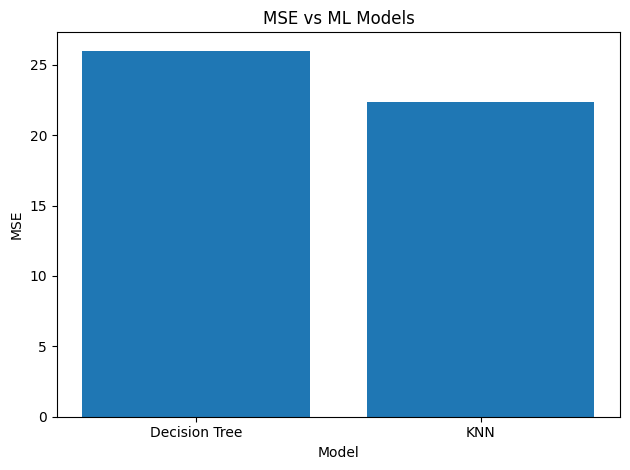

In [16]:
for colname in selected_metrics:
    fig, ax = plt.subplots()

    ax.bar(selected_models, output_df[colname])

    if len(selected_models) > 1:
        ax.set_title(f"{colname} vs ML Models")
    else:
        ax.set_title(f"{colname} vs {selected_models[0]}")

    ax.set_ylabel(colname)
    ax.set_xlabel("Model")
    fig.tight_layout()
    plt.show()